# Step 4 — ROI & Decisioning (BankChurners)

**Goal.** Convert churn probabilities into action:
- **Targeting curve**: rank customers by risk → pick coverage where cumulative profit **peaks**.
- **Threshold sweep**: KPI table for coverage/precision/recall/expected profit.
- **Sensitivity**: offer **cost × lift** heatmap (risk envelope).
- **Deliverables**: CSVs for Tableau + PNGs for README.

**Caveat.** Lift and cost are **assumptions** until validated by an A/B test.

In [1]:
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import json

BASE = Path("..")
PROC = BASE / "data" / "processed"
MODELS = BASE / "models"
OUT = BASE / "outputs"; OUT.mkdir(exist_ok=True)
TAB = BASE / "tableau"; TAB.mkdir(exist_ok=True)

# Load splits
test_df = pd.read_csv(PROC / "test.csv")
y_test  = test_df["churn"].astype(int).values
X_test  = test_df.drop(columns=["churn"])

# Load calibrated or best available probabilities saved in Step 3’s session
# If not present in this kernel, recompute quickly via Logistic (self-healing).
p = None
try:
    p = p_te_cal
except NameError:
    try:
        p = p_te_xgb
    except NameError:
        # Minimal fallback: rebuild a Logit pipeline and score
        from joblib import load
        from sklearn.linear_model import LogisticRegression
        from sklearn.pipeline import Pipeline
        pre = load(MODELS / "preprocessor.joblib")
        logit = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))])
        # Recreate y_train/X_train if needed
        train_df = pd.read_csv(PROC / "train.csv")
        y_train = train_df["churn"].astype(int).values
        X_train = train_df.drop(columns=["churn"])
        logit.fit(X_train, y_train)
        p = logit.predict_proba(X_test)[:,1]

assert p is not None, "Could not obtain probabilities; re-run Step 3 to produce p_te_cal or p_te_xgb."
p = pd.Series(p, name="p_churn")
print("Test rows:", len(p), " | Baseline churn rate:", y_test.mean().round(3))


Test rows: 2532  | Baseline churn rate: 0.161


## Economics (assumptions)

To convert risk into dollars we need 3 inputs:
- **Offer cost ($/contact)** — email/call/perk cost per targeted customer
- **Retained margin ($)** — expected net margin if a would-be attriter is retained
- **Treatment lift (abs.)** — absolute reduction in churn probability due to the offer

> We will stress-test these in a sensitivity analysis.


In [2]:
offer_cost = 1.00           # $ per targeted customer
retained_margin = 120.0     # $ net margin if retained
treatment_lift = 0.20       # absolute reduction in churn prob (e.g., 20 pp)

econ = dict(offer_cost=offer_cost, retained_margin=retained_margin, treatment_lift=treatment_lift)
econ


{'offer_cost': 1.0, 'retained_margin': 120.0, 'treatment_lift': 0.2}

## Targeting curve — find profit-optimal coverage

Rank customers by predicted churn, target the top N, and compute **cumulative expected profit**:

$$
\mathrm{EP}_i = p_i \cdot \text{lift} \cdot \text{margin} - \text{cost}
$$

Pick N where the curve **peaks** (beyond that, marginal customers reduce profit).

In [10]:
import pandas as pd, numpy as np

tc = pd.read_csv("../tableau/targeting_curve_points.csv")  # adjust path
assert {"rank","cum_expected_profit"}.issubset(tc.columns), tc.columns

# A. ranks must be sorted & start at 1
print("Rank monotonic:", tc["rank"].is_monotonic_increasing, "min/max:", tc["rank"].min(), tc["rank"].max())

# B. incremental contribution should decline as rank grows
deltas = tc["cum_expected_profit"].diff().dropna()
print("Δ profit mean:", deltas.mean(), "std:", deltas.std(), "min:", deltas.min(), "max:", deltas.max())

# C. where is the peak?
peak_idx = tc["cum_expected_profit"].idxmax()
print("Peak at N:", int(tc.loc[peak_idx, "rank"]), "Cum profit:", tc.loc[peak_idx, "cum_expected_profit"])

# D. is the curve ever going down?
print("Ever negative increment?:", (deltas < 0).any())


Rank monotonic: True min/max: 1 2532
Δ profit mean: 5.7365795496762795 std: 7.702979334415146 min: -0.9992125462540571 max: 22.989891509976125
Peak at N: 1757 Cum profit: 15023.457021272605
Ever negative increment?: True


Optimal coverage: top 1757 customers (69.4%)
Expected incremental profit at optimum: $15,023


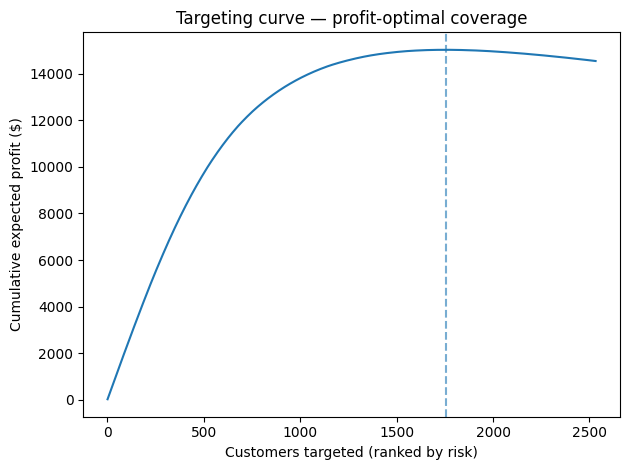

In [3]:
probs_sorted = p.sort_values(ascending=False).reset_index(drop=True)
ep = probs_sorted * treatment_lift * retained_margin - offer_cost
cum_profit = ep.cumsum()

best_k = int(cum_profit.idxmax() + 1)
best_profit = float(cum_profit.max())
coverage_pct = 100 * best_k / len(probs_sorted)

print(f"Optimal coverage: top {best_k} customers ({coverage_pct:.1f}%)")
print(f"Expected incremental profit at optimum: ${best_profit:,.0f}")

# Plot & save
plt.figure()
plt.plot(np.arange(1, len(cum_profit)+1), cum_profit.values)
plt.axvline(best_k, linestyle="--", alpha=.6)
plt.xlabel("Customers targeted (ranked by risk)"); plt.ylabel("Cumulative expected profit ($)")
plt.title("Targeting curve — profit-optimal coverage")
plt.tight_layout(); plt.savefig(OUT/"churn_targeting_curve.png", dpi=150); plt.show()

# Export points (for optional Tableau line)
tc = pd.DataFrame({"rank": np.arange(1, len(cum_profit)+1), "cum_expected_profit": cum_profit.values})
tc.to_csv(TAB/"targeting_curve_points.csv", index=False)


## Threshold sweep

We evaluate thresholds from 0.01 to 0.99, computing:
- **Coverage** (what % we target)
- **Precision / Recall / Lift**
- **Expected profit** (given current assumptions)

This powers a dashboard slider so stakeholders can pick a threshold to match budget appetite.


Wrote: ../tableau/threshold_curve.csv


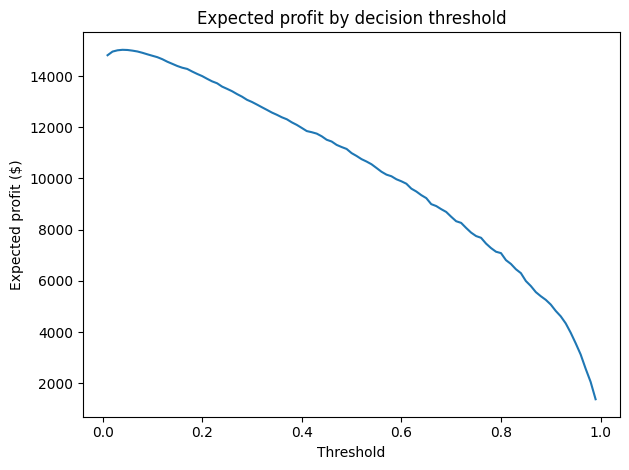

In [4]:
ths = np.linspace(0.01, 0.99, 99)
truth = pd.Series(y_test, name="y")
rows = []
for t in ths:
    target = p >= t
    k = int(target.sum())
    coverage = k / len(truth)
    tp = int(((truth==1) & target).sum())
    fp = int(((truth==0) & target).sum())
    fn = int(((truth==1) & ~target).sum())
    precision = tp/k if k else 0
    recall    = tp/(tp+fn) if (tp+fn) else 0
    baseline  = truth.mean()
    lift      = precision / baseline if baseline else 0
    exp_profit = (p[target]*treatment_lift*retained_margin).sum() - k*offer_cost
    rows.append([t, coverage, precision, recall, lift, k, tp, fp, fn, exp_profit])

thr_curve = pd.DataFrame(rows, columns=[
    "threshold","coverage","precision","recall","lift","n_target","tp","fp","fn","expected_profit"
])
thr_curve.to_csv(TAB/"threshold_curve.csv", index=False)
print("Wrote:", (TAB/"threshold_curve.csv").as_posix())

# Profit vs threshold plot
plt.figure()
plt.plot(thr_curve["threshold"], thr_curve["expected_profit"])
plt.xlabel("Threshold"); plt.ylabel("Expected profit ($)")
plt.title("Expected profit by decision threshold")
plt.tight_layout(); plt.savefig(OUT/"churn_profit_vs_threshold.png", dpi=150); plt.show()


## KPIs at profit-optimal point

We translate the **best coverage** into a **threshold**, then compute the confusion matrix and KPIs at that operating point.


Operating threshold: 0.0418
TP=406, FP=1351, FN=1, TN=774
Precision=0.231  Recall=0.998  F1=0.375


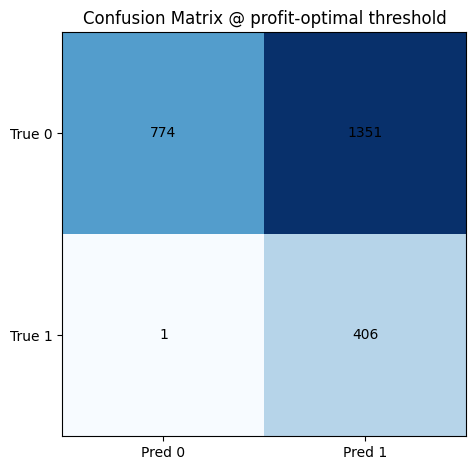

In [5]:
# Convert best_k (by rank) into an equivalent threshold
t_star = float(probs_sorted.iloc[best_k-1])
print("Operating threshold:", round(t_star, 4))

pred = (p >= t_star).astype(int)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

cm = confusion_matrix(y_test, pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
precision = precision_score(y_test, pred, zero_division=0)
recall    = recall_score(y_test, pred, zero_division=0)
f1        = f1_score(y_test, pred, zero_division=0)

print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")
print(f"Precision={precision:.3f}  Recall={recall:.3f}  F1={f1:.3f}")

# Simple confusion heatmap
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.xticks([0,1], ["Pred 0","Pred 1"])
plt.yticks([0,1], ["True 0","True 1"])
for (i,j),v in np.ndenumerate(cm):
    plt.text(j,i,str(v),ha='center',va='center')
plt.title("Confusion Matrix @ profit-optimal threshold")
plt.tight_layout(); plt.savefig(OUT/"churn_confusion_optimal.png", dpi=150); plt.show()


## Sensitivity — lift × cost

Leaders ask: “What if the treatment is weaker/stronger?” We grid **lift** and **cost** to show the **max achievable profit** under each scenario.


Wrote: ../tableau/roi_sensitivity.csv


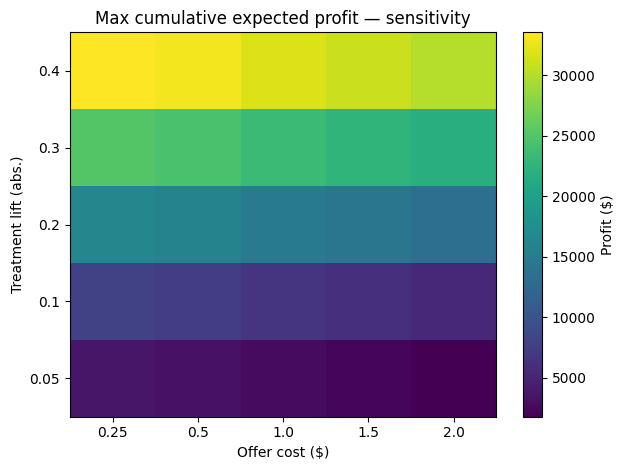

In [6]:
lifts = np.array([0.05, 0.10, 0.20, 0.30, 0.40])
costs = np.array([0.25, 0.50, 1.00, 1.50, 2.00])
probs_sorted = p.sort_values(ascending=False).reset_index(drop=True)

rows = []
for L in lifts:
    for C in costs:
        ep = probs_sorted * L * retained_margin - C
        rows.append([L, C, float(ep.cumsum().max())])

sens = pd.DataFrame(rows, columns=["lift_abs","offer_cost","max_cum_profit"])
sens.to_csv(TAB/"roi_sensitivity.csv", index=False)
print("Wrote:", (TAB/"roi_sensitivity.csv").as_posix())

# Heatmap (quick)
pivot = sens.pivot(index="lift_abs", columns="offer_cost", values="max_cum_profit")
plt.figure()
plt.imshow(pivot.values, aspect="auto", origin="lower")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel("Offer cost ($)"); plt.ylabel("Treatment lift (abs.)")
plt.title("Max cumulative expected profit — sensitivity")
plt.colorbar(label="Profit ($)")
plt.tight_layout(); plt.savefig(OUT/"churn_roi_sensitivity.png", dpi=150); plt.show()


## Customer-level export (for Tableau)

We output test customers with:
- `id`, `churn_true`, `p_churn`
- **decile** (rank by risk)
- a few slice dimensions (e.g., `gender`, `customer_age`, etc.)


In [7]:
scored = pd.DataFrame({
    "id": X_test["id"].values if "id" in X_test.columns else np.arange(len(p)),
    "churn_true": y_test,
    "p_churn": p.values
}).sort_values("p_churn", ascending=False).reset_index(drop=True)

scored["rank"] = scored.index + 1
scored["decile"] = pd.qcut(scored["rank"], 10, labels=list(range(10,0,-1)))

# Optional slice dims (only those that exist in X_test)
dims = [c for c in ["gender","customer_age","income_category","card_category",
                    "months_inactive_12_mon","total_trans_ct"] if c in X_test.columns]
scored = pd.concat([scored, X_test[dims].reset_index(drop=True)], axis=1)

scored.to_csv(TAB/"customer_scored.csv", index=False)
print("Wrote:", (TAB/"customer_scored.csv").as_posix(), "→", scored.shape)


Wrote: ../tableau/customer_scored.csv → (2532, 11)


## A/B test sizing

We estimate per-group sample size for a **two-proportion** test:
- Baseline event = test churn rate × (selected coverage)
- Minimal detectable effect = **lift_abs**
- α = 0.05, power = 0.80


In [8]:
from math import ceil, sqrt
try:
    from scipy.stats import norm
    z_alpha = norm.ppf(1-0.05/2)   # two-sided
    z_beta  = norm.ppf(0.80)
except Exception:
    z_alpha, z_beta = 1.96, 0.84

# Use operating threshold t_star from Cell 9 (or baseline)
p_base = y_test.mean()
p_treat = max(p_base - treatment_lift, 1e-6)  # absolute reduction
p_bar = (p_base + p_treat)/2
delta = abs(p_base - p_treat)

n_per_group = ceil( 2 * ( z_alpha*sqrt(2*p_bar*(1-p_bar)) + z_beta*sqrt(p_base*(1-p_base) + p_treat*(1-p_treat)) )**2 / (delta**2) )
print(f"Approx. n per arm for A/B (α=0.05, power=0.80): {n_per_group:,}")


Approx. n per arm for A/B (α=0.05, power=0.80): 88
